In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile, os, zipfile
from PIL import Image
import requests
from matplotlib import pyplot as plt
#mport squarify
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from os import listdir
from os.path import isfile, join

In [2]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.com.am/d/1mFfgWQxggpeUQ'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)

download_url = response.json()['href']

download_response = requests.get(download_url)


file = tempfile.TemporaryFile()
file.write(download_response.content)
fzip = zipfile.ZipFile(file)
fzip.extractall('./TJ_data')

file.close()
fzip.close()


In [3]:
listdir("./TJ_data") # Tom&Jerry_dataset
listdir("./TJ_data/Tom&Jerry_dataset")

['archive.zip']

In [4]:
fzip = zipfile.ZipFile("./TJ_data/Tom&Jerry_dataset/archive.zip")
fzip.extractall('./TJ_data/dataset')

fzip.close()

In [5]:
dataset_dir = "./TJ_data/dataset"
tom_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/tom"
jerry_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/jerry"
tj_0_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/tom_jerry_0"
tj_1_dir = "./TJ_data/dataset/tom_and_jerry/tom_and_jerry/tom_jerry_1"

print(listdir(dataset_dir))


['challenges.csv', 'tom_and_jerry', 'ground_truth.csv']


In [6]:
import os
import numpy as np
from PIL import Image

folder_path = './TJ_data/dataset/tom_and_jerry/tom_and_jerry/'


def images_to_array(folder_path, class_name):

    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    data = []
    target= []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        img = Image.open(image_path)

        img = img.resize((224, 224))

        img_array = np.array(img, dtype=float) / 255.0  # Нормализация значений пикселей к диапазону [0, 1]
        img_vector = img_array.flatten()

        data.append(img_vector)
        target.append(class_names.index(class_name))


    result_array = np.array(data)
    target_array = np.array(target)
    return result_array, target_array

folder_path = './TJ_data/dataset/tom_and_jerry/tom_and_jerry/'
class_names =  ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
result_array = None
target_result_array = None


for class_name in class_names:
    class_directory = os.path.join(folder_path, class_name)
    class_array, target_array = images_to_array(class_directory, class_name)

    if result_array is None:
        result_array = class_array
    else:
        result_array = np.concatenate((result_array, class_array))
    if target_result_array is None:
        target_result_array=target_array
    else:
        target_result_array=np.concatenate((target_result_array, target_array))

print(result_array.shape)
print(target_result_array.shape)


(5478, 150528)
(5478,)


In [7]:
!pip install tensorflow
import tensorflow as tf


In [9]:
#Setting Constraints
IMAGE_DIRECTORY = "/content/TJ_data/dataset/tom_and_jerry/tom_and_jerry"

batch_size = 32
img_height = 72
img_width = 128

#Loading the dataset and splitting into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


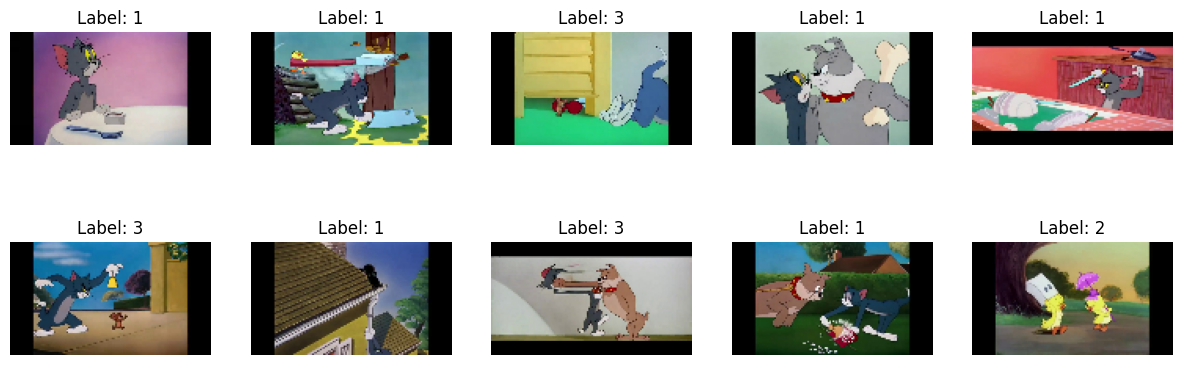

In [11]:
plt.figure(figsize=(15, 5))
for i, (images, labels) in enumerate(train_ds.take(1)):
    for j in range(10):
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")
plt.show()

In [12]:
num_classes = len(set(label for _, labels in train_ds for label in labels.numpy()))
print("Number of Classes:", num_classes)

Number of Classes: 4


In [13]:
#Labeling categories
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# CNN model architecture
cnn_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [20]:
# Compiling the model
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# Training the model
epochs = 10
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
137/137 [==============================] - 15s 97ms/step - loss: 1.2421 - accuracy: 0.4298 - val_loss: 1.1397 - val_accuracy: 0.4968
Epoch 2/10
137/137 [==============================] - 14s 98ms/step - loss: 0.8932 - accuracy: 0.6454 - val_loss: 0.7826 - val_accuracy: 0.7087
Epoch 3/10
137/137 [==============================] - 14s 98ms/step - loss: 0.6196 - accuracy: 0.7714 - val_loss: 0.6822 - val_accuracy: 0.7461
Epoch 4/10
137/137 [==============================] - 13s 94ms/step - loss: 0.4625 - accuracy: 0.8284 - val_loss: 0.5488 - val_accuracy: 0.8055
Epoch 5/10
137/137 [==============================] - 13s 96ms/step - loss: 0.3493 - accuracy: 0.8768 - val_loss: 0.5366 - val_accuracy: 0.8183
Epoch 6/10
137/137 [==============================] - 13s 95ms/step - loss: 0.2403 - accuracy: 0.9115 - val_loss: 0.5623 - val_accuracy: 0.8210
Epoch 7/10
137/137 [==============================] - 13s 94ms/step - loss: 0.1841 - accuracy: 0.9334 - val_loss: 0.5411 - val_accuracy:

In [22]:
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 72, 128, 3)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 128, 16)       448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 36, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 18, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 32, 64)       

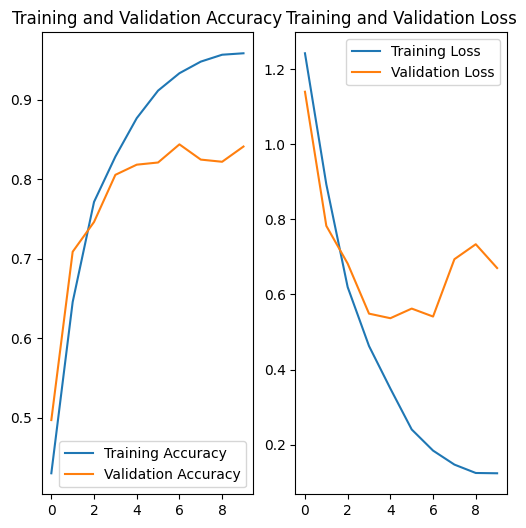

In [23]:
# accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 24ms/step


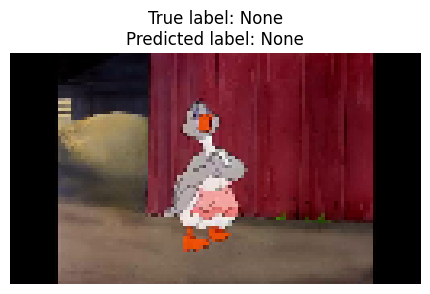

In [26]:
# Predicting one image from the validation dataset
plt.figure(figsize=(6, 3))
for images, labels in val_ds.take(1):
    sample_image = images[2]
    true_label = labels[2]

    sample_image = tf.expand_dims(sample_image, axis=0)

    predictions = cnn_model.predict(sample_image)

    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
    predicted_class = label_categories[predicted_class_index]

    plt.imshow(sample_image[0].numpy().astype("uint8"))
    plt.title(f"True label: {label_categories[true_label.numpy()]}\nPredicted label: {predicted_class}")
    plt.axis('off')

plt.show()